In [23]:
import os, glob
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras import layers
from keras.models import Model
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications import EfficientNetB7
from keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from keras.applications import EfficientNetV2M
from keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess_input
from keras.applications import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input

# <span style="color: blue;">Read data and save in a dataframe</span>


Colab

In [ ]:
!gdown 1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
!gdown 1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6
! unzip train_data.zip -d /content/train_data
! unzip test_data.zip -d /content/test_data

In [ ]:
train_data_dir = '/content/train_data/train_data'
test_data_dir = '/content/test_data/test_data'
kaggle = False
path=''

Kaggle

In [2]:
train_data_dir = '/kaggle/input/image-prooduct-quera/train_data/train_data'
test_data_dir = '/kaggle/input/image-prooduct-quera/test_data/test_data'
kaggle = True
path='/kaggle/working/'

Save Class Names

In [3]:
class_names = os.listdir(train_data_dir)
class_names

['7', '2', '10', '5', '8', '3', '1', '4', '9', '6']

Read Path of all Train Images

In [10]:
image_dirs = list(glob.glob(train_data_dir + '/**/*.*'))
test_image_dirs = list(glob.glob(test_data_dir + '/*.*'))

In [6]:
len(image_dirs)

9990

Read Label of Train Images

In [7]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_dirs))

In [7]:
len(labels)

9990

Create DataFrame of Paths and Labels

In [8]:
data = pd.DataFrame({'image_dir':image_dirs, 'label': labels})
data.head()

,image_dir,label
0,/kaggle/input/image-prooduct-quera/train_data/...,7
1,/kaggle/input/image-prooduct-quera/train_data/...,7
2,/kaggle/input/image-prooduct-quera/train_data/...,7
3,/kaggle/input/image-prooduct-quera/train_data/...,7
4,/kaggle/input/image-prooduct-quera/train_data/...,7


In [11]:
test_data = pd.DataFrame({'image_dir':test_image_dirs})
test_data.head()

,image_dir
0,/kaggle/input/image-prooduct-quera/test_data/t...
1,/kaggle/input/image-prooduct-quera/test_data/t...
2,/kaggle/input/image-prooduct-quera/test_data/t...
3,/kaggle/input/image-prooduct-quera/test_data/t...
4,/kaggle/input/image-prooduct-quera/test_data/t...


Check Number of Samples in each Class

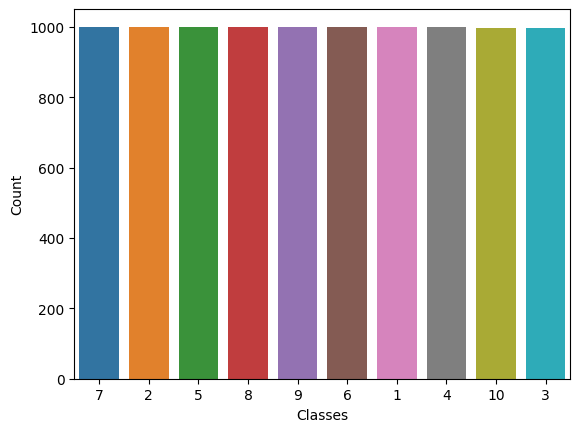

In [8]:
counts = data['label'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.show()

### Plot some images in each class

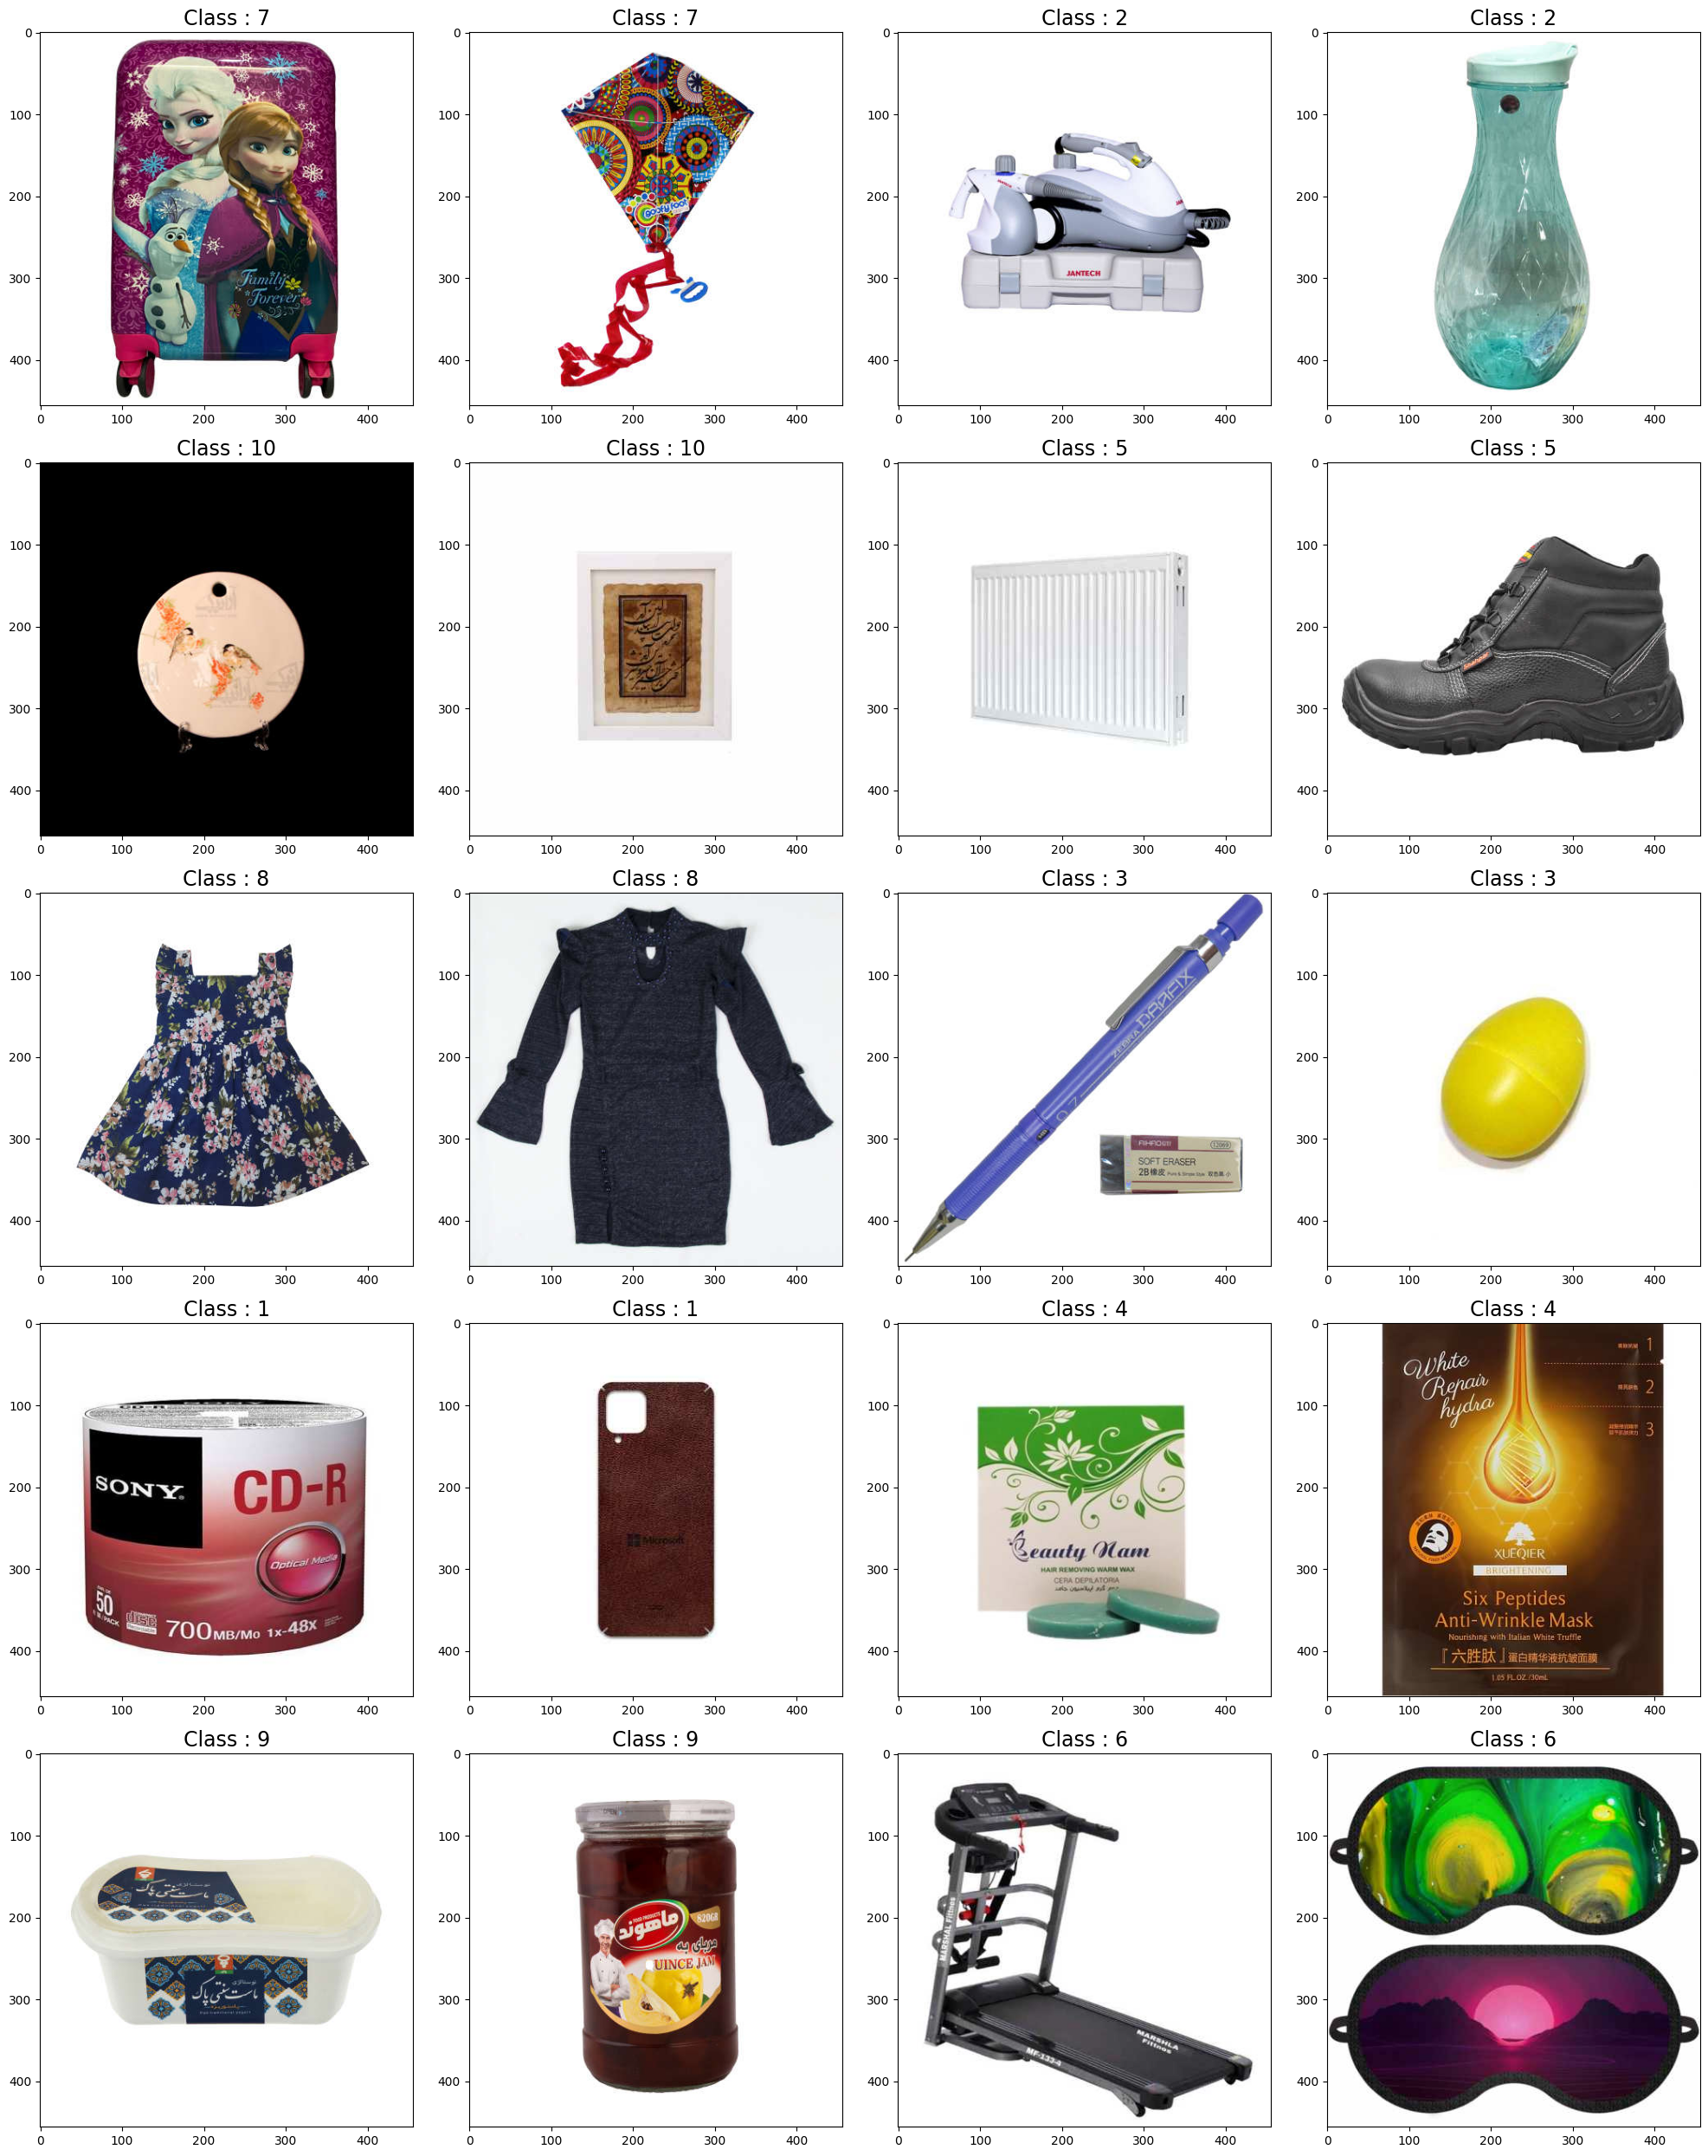

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,25))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data['image_dir'][i * 500]))
    ax.set_title('Class : ' + data['label'][i * 500], fontsize=17)
plt.tight_layout()
plt.show()

# <span style="color: blue;">Define Functions</span>

## Function for generators of train , validation and test

In [13]:
def create_generators(data, 
                      test_size, 
                      preprocessing_function,
                      batch_size = 32,
                      image_size = (224, 224)
                     ):
    
    # Split Data to Tain and Validation
    train, validation = train_test_split(data, test_size=test_size, random_state=42)
    train = train.reset_index(drop=True)
    validation = validation.reset_index(drop=True)
    
    # Create Data Generators
    train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocessing_function,
    rotation_range=15, 
#     width_shift_range=0.2,  
#     height_shift_range=0.2, 
    brightness_range=[0.8,1.2],
    shear_range=0.2,  
#     zoom_range=0.2, 
    horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='nearest' 
    )
    
    test_data_generator = ImageDataGenerator(
            preprocessing_function=preprocessing_function
        )

    train_generator = train_data_generator.flow_from_dataframe(
        dataframe= train,
        x_col='image_dir',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True,
        seed=42
    )
    validation_generator = test_data_generator.flow_from_dataframe(
        dataframe= validation,
        x_col='image_dir',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )

    # test_generator = test_data_generator
    
    return train_generator, validation_generator, test_data_generator

In [14]:
def create_generators2(train_data_dir,
                       test_data_dir,
                      preprocessing_function,
                      batch_size = 32,
                      image_size = (224, 224),
                      validation_split=0.3
                     ):
    # Create Data Generators
    train_data_generator = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=validation_split 
    )

    test_data_generator = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=validation_split  
    )

    
    train_generator = train_data_generator.flow_from_directory(
        directory=train_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset='training', 
        seed=42
    )
    
    validation_generator = train_data_generator.flow_from_directory(
        directory=train_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset='validation',  
        seed=42
    )

    return train_generator, validation_generator, test_data_generator

In [15]:
def augment_batch(x_batch, y_batch, data_gen: ImageDataGenerator, n=2):
    augmented_images = []
    augmented_labels = []
    
    for x, y in zip(x_batch, y_batch):
        
        augmented_images.append(x)
        augmented_labels.append(y)
        
        for i in range(1,n):
            x_aug = data_gen.random_transform(x)
            augmented_images.append(x_aug)
            augmented_labels.append(y)
    
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    
    indices = np.arange(augmented_images.shape[0])
    np.random.shuffle(indices)
    augmented_images = augmented_images[indices]
    augmented_labels = augmented_labels[indices]
    
    return augmented_images, augmented_labels

In [16]:
def custom_generator(generator, data_gen, n=2):
    for x_batch, y_batch in generator:
        x_batch_aug, y_batch_aug = augment_batch(x_batch, y_batch, data_gen, n)
        yield x_batch_aug, y_batch_aug

## Functions make pretrained model as base model 

In [17]:
def make_base_model(model=ResNet50,
                    image_size=(224,224),
                    num_classes=10,
                    num_trainable_layeres=0,
                    kaggle=False,
                    weights_path=None,
                   ):
    
    # base_model
    if kaggle:
        # Kaggle
        base_model = model(
        input_shape=(image_size[0], image_size[1], 3),
        classes=num_classes,
        include_top=False, 
        weights=None,
        pooling=None #'avg'
        )
        base_model.load_weights(weights_path)
    else:
        # Colab
        base_model = model(
        input_shape=(image_size[0], image_size[1], 3),
        classes=num_classes,
        include_top=False, 
        weights='imagenet',
        pooling=None #'avg'
        )
    for layer in base_model.layers:
        layer.trainable = False
    if num_trainable_layeres > 0:
        for layer in base_model.layers[-num_trainable_layeres : ]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True    
    
    return base_model

## Function for add our layeres to base model

In [24]:
def try_model(base_model, 
              n_added_layers=2, 
              filters=[128,128], 
              activations=['relu', 'relu'],
              regulizer=False,
              augmentation_layer=False,
              num_classes=10,
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy']):
    if augmentation_layer:
        data_augmentation = keras.Sequential(
        [
        layers.RandomRotation(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        ]
        )
        inputs = base_model.input
        x = data_augmentation(inputs)
#         scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
#         x = scale_layer(x)
        x = base_model(x, training=False)
        x = GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = keras.layers.Dropout(0.2)(x) 
        
    else:
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = keras.layers.Dropout(0.2)(x) 
        
    for i in range(n_added_layers):
        if regulizer:
            x = Dense(filters[i], activation='relu', kernel_regularizer=l2(0.01))(x)
        else:
            x = Dense(filters[i], activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    trainable_params = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")
    
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=metrics)
#     model.summary()
    return model

## Functions for evaluation metrics 

In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_micro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

## Functions for save and load models

In [20]:
def save_model(model, filename, path=''):
    filename_json = os.path.join(path, filename + '.json')
    filename_h5 = os.path.join(path, filename + '.h5')

    # serialize model to JSON
    model_json = model.to_json()
    with open(filename_json, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(filename_h5)
    print("Saved model to ", filename_h5 )
    
def load_model(model, filename, path=''):
    filename_json = os.path.join(path, filename + '.json')
    filename_h5 = os.path.join(path, filename + '.h5')
    
    # load json and create model
    json_file = open(filename_json , 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(filename_h5)
    return loaded_model

In [21]:
train_data_generator = ImageDataGenerator(
        rotation_range=15,
        brightness_range=[0.8,1.2],
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# <span style="color: blue;">Try Models</span>

## <span style="color: green;">ResNet 50</span>

In [ ]:
batch_size = 32
image_size = (224, 224)

train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.3, 
                      preprocessing_function= resnet50_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )

### ResNet 50 | train 0 layers 

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=0,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 0,
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_0_layers', 
           path=path)

### ResNet 50 | train 0 layers | add 2 dense layer with 128 filters

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=0,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [128,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_0_add_2_layers', 
           path=path)

### ResNet 50 | train 5 last layers | add 2 dense layers both with 128 filters

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=5,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [128,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_5_add_2_layers_128_128', 
           path=path)

### ResNet 50 | train 10 last layers | add 2 dense layer with 256 and 128 filters

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=10,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_10_add_2_layers_256_128', 
           path=path)

### ResNet 50 | train 15 last layers | add 2 dense layer with 256 and 128 filters

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=15,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_15_add_2_layers_256_128', 
           path=path)

### ResNet 50 | train 20 last layers | add 2 dense layer with 256 and 128 filters | lr : 1e-4

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_20_add_2_layers_256_128_lr-4', 
           path=path)

### ResNet 50 | train 25 last layers | add 2 dense layer with 256 and 128 filters | lr : 1e-4

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=25,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_25_add_2_layers_256_128_lr-4', 
           path=path)

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=45,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_45_add_2_layers_256_128_lr-4', 
           path=path)

In [ ]:
resnet50_weights_path = '/kaggle/input/resnet50-weights-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = make_base_model(model=ResNet50,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=resnet50_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='resnet50_train_20_add_2_layers_256_128_lr-4', 
           path=path)

## <span style="color: green;">EfficientNet</span>

### V2 M

with Image data generator augmentation

In [22]:
batch_size = 32
image_size = (380, 380)
train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.2, 
                      preprocessing_function= efficientnet_v2_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )

Found 7992 validated image filenames belonging to 10 classes.
Found 1998 validated image filenames belonging to 10 classes.


In [ ]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr-4', 
           path=path)

Total params: 53,517,630
Trainable params: 4,983,050
Non-trainable params: 48,534,580
Epoch 1/50


2023-11-11 04:33:34.394102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 426s 2s/step - loss: 1.6502 - accuracy: 0.4562 - f1_micro: 0.3472 - val_loss: 1.3835 - val_accuracy: 0.5946 - val_f1_micro: 0.3499
Epoch 2/50
250/250 [==============================] - 339s 1s/step - loss: 1.1439 - accuracy: 0.6234 - f1_micro: 0.5797 - val_loss: 1.1042 - val_accuracy: 0.6331 - val_f1_micro: 0.6136
Epoch 3/50
250/250 [==============================] - 337s 1s/step - loss: 0.9631 - accuracy: 0.6802 - f1_micro: 0.6542 - val_loss: 1.0198 - val_accuracy: 0.6672 - val_f1_micro: 0.6506
Epoch 4/50
250/250 [==============================] - 335s 1s/step - loss: 0.8123 - accuracy: 0.7266 - f1_micro: 0.7066 - val_loss: 0.9931 - val_accuracy: 0.6837 - val_f1_micro: 0.6761
Epoch 5/50
250/250 [==============================] - 333s 1s/step - loss: 0.6982 - accuracy: 0.7654 - f1_micro: 0.7587 - val_loss: 1.0072 - val_accuracy: 0.6827 - val_f1_micro: 0.6838
Epoch 6/50
250/250 [==============================] - 337s 1s/step - loss: 0.5792 - ac

In [ ]:
model.evaluate(validation_generator)

In [31]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr-4', 
           path=path)

Total params: 53,517,630
Trainable params: 4,983,050
Non-trainable params: 48,534,580
Epoch 1/50


2023-11-10 16:17:37.624098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 421s 2s/step - loss: 1.6394 - accuracy: 0.4566 - f1_micro: 0.3517 - val_loss: 1.3909 - val_accuracy: 0.5916 - val_f1_micro: 0.3478
Epoch 2/50
250/250 [==============================] - 334s 1s/step - loss: 1.1523 - accuracy: 0.6230 - f1_micro: 0.5822 - val_loss: 1.1210 - val_accuracy: 0.6426 - val_f1_micro: 0.5912
Epoch 3/50
250/250 [==============================] - 339s 1s/step - loss: 0.9642 - accuracy: 0.6782 - f1_micro: 0.6559 - val_loss: 1.0499 - val_accuracy: 0.6582 - val_f1_micro: 0.6404
Epoch 4/50
250/250 [==============================] - 335s 1s/step - loss: 0.8310 - accuracy: 0.7207 - f1_micro: 0.7019 - val_loss: 1.0376 - val_accuracy: 0.6732 - val_f1_micro: 0.6702
Epoch 5/50
250/250 [==============================] - 335s 1s/step - loss: 0.6895 - accuracy: 0.7750 - f1_micro: 0.7621 - val_loss: 1.0675 - val_accuracy: 0.6727 - val_f1_micro: 0.6732
Epoch 6/50
250/250 [==============================] - 334s 1s/step - loss: 0.5881 - ac

In [32]:
model.evaluate(validation_generator)

63/63 [==============================] - 35s 549ms/step - loss: 1.3322 - accuracy: 0.7207 - f1_micro: 0.7237


[1.3321515321731567, 0.7207207083702087, 0.7237198352813721]

In [ ]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              regulizer=True,
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr-4_l2', 
           path=path)

Total params: 53,517,630
Trainable params: 4,983,050
Non-trainable params: 48,534,580
Epoch 1/50


2023-11-11 21:02:24.522339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 457s 2s/step - loss: 7.3522 - accuracy: 0.4586 - f1_micro: 0.3494 - val_loss: 6.7619 - val_accuracy: 0.6006 - val_f1_micro: 0.3295
Epoch 2/50
250/250 [==============================] - 344s 1s/step - loss: 6.2133 - accuracy: 0.6180 - f1_micro: 0.5736 - val_loss: 5.8572 - val_accuracy: 0.6331 - val_f1_micro: 0.6053
Epoch 3/50
250/250 [==============================] - 343s 1s/step - loss: 5.4404 - accuracy: 0.6735 - f1_micro: 0.6452 - val_loss: 5.2198 - val_accuracy: 0.6597 - val_f1_micro: 0.6408
Epoch 4/50
 85/250 [=========>....................] - ETA: 3:23 - loss: 4.9411 - accuracy: 0.7224 - f1_micro: 0.6847

In [ ]:
model.evaluate(validation_generator)

In [ ]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-3),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr1e-3', 
           path=path)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=5e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr5e-4', 
           path=path)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [128,64], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=5e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_128_64_lr5e-4', 
           path=path)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
pred = model.predict(validation_generator)


my augmentation function

In [39]:
batch_size = 32
image_size = (380, 380)
train_generator, validation_generator, test_data_generator = create_generators2(train_data_dir,
                      test_data_dir,
                      validation_split=0.2,
                      preprocessing_function= efficientnet_v2_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                      
                     )

Found 7994 images belonging to 10 classes.
Found 1996 images belonging to 10 classes.


In [40]:
efficientnet_v2_weights_path = '/kaggle/input/efficientnetv2-m-notop/efficientnetv2-m_notop.h5'
base_model = make_base_model(model=EfficientNetV2M,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=efficientnet_v2_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=5e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    custom_generator(train_generator, train_data_generator, n=2),
    steps_per_epoch=train_generator.samples // batch_size + 100,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='efficient_v2_M_train_20_add_2_layers_256_128_lr5e-4', 
           path=path)

Total params: 53,517,630
Trainable params: 4,983,050
Non-trainable params: 48,534,580
Epoch 1/50


2023-11-10 19:10:21.362575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


349/349 [==============================] - 605s 2s/step - loss: 1.2490 - accuracy: 0.5875 - f1_micro: 0.5468 - val_loss: 1.0667 - val_accuracy: 0.6381 - val_f1_micro: 0.6046
Epoch 2/50
349/349 [==============================] - 570s 2s/step - loss: 0.8017 - accuracy: 0.7305 - f1_micro: 0.7206 - val_loss: 1.0713 - val_accuracy: 0.6552 - val_f1_micro: 0.6552
Epoch 3/50
349/349 [==============================] - 567s 2s/step - loss: 0.5395 - accuracy: 0.8196 - f1_micro: 0.8183 - val_loss: 1.0741 - val_accuracy: 0.6900 - val_f1_micro: 0.6919
Epoch 4/50
349/349 [==============================] - 568s 2s/step - loss: 0.3662 - accuracy: 0.8748 - f1_micro: 0.8742 - val_loss: 1.1904 - val_accuracy: 0.6951 - val_f1_micro: 0.6895
Epoch 5/50
349/349 [==============================] - 568s 2s/step - loss: 0.3056 - accuracy: 0.8979 - f1_micro: 0.8981 - val_loss: 1.2077 - val_accuracy: 0.6885 - val_f1_micro: 0.6978
Epoch 6/50
349/349 [==============================] - 567s 2s/step - loss: 0.2592 - ac

In [ ]:
model.evaluate(validation_generator)

## <span style="color: green;">Xception</span>

In [47]:
batch_size = 16
image_size = (299, 299)

train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.3, 
                      preprocessing_function= xception_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )

Found 6993 validated image filenames belonging to 10 classes.
Found 2997 validated image filenames belonging to 10 classes.


In [48]:
batch_size = 16
image_size = (299, 299)
train_generator, validation_generator, test_data_generator = create_generators2(train_data_dir,
                      test_data_dir,
                      validation_split=0.3,
                      preprocessing_function= xception_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                      
                     )

Found 6994 images belonging to 10 classes.
Found 2996 images belonging to 10 classes.


In [49]:
xception_weights_path = '/kaggle/input/xception-weights-notop/xception-weights-notop.h5'
base_model = make_base_model(model=Xception,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=xception_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    custom_generator(train_generator, train_data_generator, n=4),
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='xception_train_20_add_2_layers_256_128_lr-4', 
           path=path)

Total params: 21,428,402
Trainable params: 7,875,026
Non-trainable params: 13,553,376
Epoch 1/50
437/437 [==============================] - 529s 1s/step - loss: 1.5847 - accuracy: 0.4695 - f1_micro: 0.3839 - val_loss: 1.2995 - val_accuracy: 0.5682 - val_f1_micro: 0.4936
Epoch 2/50
437/437 [==============================] - 525s 1s/step - loss: 1.0343 - accuracy: 0.6555 - f1_micro: 0.6192 - val_loss: 1.1878 - val_accuracy: 0.6153 - val_f1_micro: 0.5878
Epoch 3/50
437/437 [==============================] - 524s 1s/step - loss: 0.7103 - accuracy: 0.7657 - f1_micro: 0.7516 - val_loss: 1.2091 - val_accuracy: 0.6223 - val_f1_micro: 0.6156
Epoch 4/50
437/437 [==============================] - 530s 1s/step - loss: 0.4509 - accuracy: 0.8576 - f1_micro: 0.8480 - val_loss: 1.2197 - val_accuracy: 0.6380 - val_f1_micro: 0.6353
Epoch 5/50
437/437 [==============================] - 525s 1s/step - loss: 0.2883 - accuracy: 0.9116 - f1_micro: 0.9091 - val_loss: 1.3002 - val_accuracy: 0.6484 - val_f1_mic

In [50]:
model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

187/187 [==============================] - 24s 126ms/step - loss: 1.6112 - accuracy: 0.6591 - f1_micro: 0.6658


[1.6111572980880737, 0.6590909361839294, 0.6657763123512268]

In [17]:
batch_size = 32
image_size = (299, 299)
train_generator, validation_generator, test_data_generator = create_generators2(train_data_dir,
                      test_data_dir,
                      validation_split=0.2,
                      preprocessing_function= xception_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                      
                     )

Found 7994 images belonging to 10 classes.
Found 1996 images belonging to 10 classes.


with my augmentation function

In [ ]:
xception_weights_path = '/kaggle/input/xception-weights-notop/xception-weights-notop.h5'
base_model = make_base_model(model=Xception,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=xception_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-5),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    custom_generator(train_generator, train_data_generator, n=2),
    steps_per_epoch=train_generator.samples // batch_size + 100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='xception_train_20_add_2_layers_256_128_lr-5', 
           path=path)

Total params: 21,428,402
Trainable params: 7,875,026
Non-trainable params: 13,553,376
Epoch 1/100
349/349 [==============================] - 424s 1s/step - loss: 2.1348 - accuracy: 0.2818 - f1_micro: 0.1365 - val_loss: 1.6657 - val_accuracy: 0.4486 - val_f1_micro: 0.2104
Epoch 2/100
349/349 [==============================] - 345s 990ms/step - loss: 1.5452 - accuracy: 0.4793 - f1_micro: 0.3583 - val_loss: 1.4026 - val_accuracy: 0.5202 - val_f1_micro: 0.4316
Epoch 3/100
349/349 [==============================] - 348s 998ms/step - loss: 1.3261 - accuracy: 0.5604 - f1_micro: 0.4719 - val_loss: 1.3052 - val_accuracy: 0.5539 - val_f1_micro: 0.5037
Epoch 4/100
349/349 [==============================] - 348s 998ms/step - loss: 1.1888 - accuracy: 0.6051 - f1_micro: 0.5423 - val_loss: 1.2427 - val_accuracy: 0.5827 - val_f1_micro: 0.5345
Epoch 5/100
349/349 [==============================] - 352s 1s/step - loss: 1.0890 - accuracy: 0.6413 - f1_micro: 0.5855 - val_loss: 1.2009 - val_accuracy: 0.596

In [ ]:
model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

In [ ]:
batch_size = 32
image_size = (299, 299)

train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.2, 
                      preprocessing_function= xception_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )

with Image data generator augmentation

In [ ]:
xception_weights_path = '/kaggle/input/xception-weights-notop/xception-weights-notop.h5'
base_model = make_base_model(model=Xception,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=xception_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-5),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='xception_train_20_add_2_layers_256_128_lr-5', 
           path=path)

In [ ]:
model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

In [63]:
xception_weights_path = '/kaggle/input/xception-weights-notop/xception-weights-notop.h5'
base_model = make_base_model(model=Xception,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=xception_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [256,128], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-4),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='xception_train_20_add_2_layers_256_128_lr-4', 
           path=path)

Total params: 21,428,402
Trainable params: 7,875,026
Non-trainable params: 13,553,376
Epoch 1/50
250/250 [==============================] - 210s 825ms/step - loss: 1.6107 - accuracy: 0.4635 - f1_micro: 0.3760 - val_loss: 1.4052 - val_accuracy: 0.5470 - val_f1_micro: 0.3882
Epoch 2/50
250/250 [==============================] - 204s 814ms/step - loss: 1.0996 - accuracy: 0.6356 - f1_micro: 0.6023 - val_loss: 1.1799 - val_accuracy: 0.6181 - val_f1_micro: 0.5897
Epoch 3/50
250/250 [==============================] - 204s 816ms/step - loss: 0.8277 - accuracy: 0.7202 - f1_micro: 0.7010 - val_loss: 1.1338 - val_accuracy: 0.6446 - val_f1_micro: 0.6263
Epoch 4/50
250/250 [==============================] - 203s 809ms/step - loss: 0.6215 - accuracy: 0.7987 - f1_micro: 0.7832 - val_loss: 1.1198 - val_accuracy: 0.6537 - val_f1_micro: 0.6439
Epoch 5/50
250/250 [==============================] - 204s 815ms/step - loss: 0.4506 - accuracy: 0.8584 - f1_micro: 0.8510 - val_loss: 1.2006 - val_accuracy: 0.64

In [64]:
model.evaluate(validation_generator)

63/63 [==============================] - 16s 248ms/step - loss: 1.4736 - accuracy: 0.6857 - f1_micro: 0.6917


[1.4736415147781372, 0.6856856942176819, 0.6916950345039368]

In [ ]:
xception_weights_path = '/kaggle/input/xception-weights-notop/xception-weights-notop.h5'
base_model = make_base_model(model=Xception,
                    image_size=image_size,
                    num_classes=len(class_names),
                    num_trainable_layeres=20,
                    kaggle=kaggle,
                    weights_path=xception_weights_path,
                   )

model = try_model(base_model, 
              n_added_layers= 2, 
              filters= [128,64], 
              activations= ['relu', 'relu'], 
              num_classes= len(class_names),
              optimizer= Adam(learning_rate=1e-5),
              metrics= ['accuracy', f1_micro])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_f1_micro',
                                               min_delta=0,
                                               patience=10,
                                               mode='max',
                                               restore_best_weights=True)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

# save model
save_model(model, 
           filename='xception_train_20_add_2_layers_128_64_lr-4_ts0.2_wo_step', 
           path=path)

In [ ]:
model.evaluate(validation_generator)

# Evaluation on validation

In [ ]:
class_map = train_generator.class_indices
inverse_class_map = {v: int(k) for k, v in class_map.items()}
actual_flat_val = validation_generator.classes

predicted_labels_val = np.argmax(model.predict(validation_generator), axis=1)

predicted_labels_val = [inverse_class_map[label] for label in predicted_labels_val]
true_labels_val = [inverse_class_map[label] for label in actual_flat_val]
print("Classification Report: \n", classification_report(true_labels_val, predicted_labels_val, labels=list(range(0,11))))

In [ ]:
batch_size = 32
image_size = (380, 380)
train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.2, 
                      preprocessing_function= xception_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )
x_batch, y_batch = next(validation_generator) 
true_label_batch = [inverse_class_map[label] for label in np.argmax(y_batch, axis=1)]
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i])
    ax.set_title(f'true: {true_label_batch[i]}, pred: {predicted_labels[i]}')
plt.tight_layout()
plt.show()

# Test and savel results

In [ ]:
batch_size = 32
image_size = (299, 299)

train_generator, validation_generator, test_data_generator = create_generators(data, 
                      test_size= 0.3, 
                      preprocessing_function= efficientnet_v2_preprocess_input,
                      batch_size = batch_size,
                      image_size = image_size
                     )
test_generator = test_data_generator.flow_from_dataframe(
    test_data,
    x_col='image_dir',
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None, 
    shuffle=False 
)

class_map = train_generator.class_indices
inverse_class_map = {v: int(k) for k, v in class_map.items()}

predicted_labels = np.argmax(model.predict(test_generator), axis=1)

predicted_labels = [inverse_class_map[label] for label in predicted_labels]

df_prediction = pd.DataFrame({'name':test_generator.filenames,
                              'predicted':predicted_labels})

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_prediction.loc[i,'name']))
    ax.set_title('Class: ' + str(df_prediction.loc[i,'predicted']))
plt.tight_layout()
plt.show()


In [ ]:
class_map = train_generator.class_indices
inverse_class_map = {v: int(k) for k, v in class_map.items()}
actual_flat_val = validation_generator.classes

predicted_labels_val = np.argmax(model.predict(validation_generator), axis=1)

predicted_labels_val = [inverse_class_map[label] for label in predicted_labels_val]
true_labels_val = [inverse_class_map[label] for label in actual_flat_val]
print("Classification Report: \n", classification_report(true_labels_val, predicted_labels_val, labels=list(range(0,11))))